**Part 1**

**Co-Adaptation**: Co-Adaptation refers to the process in Convolutional Neural Networks (CNNs) where each filter adapts to learn specialized shapes present in the images through a training process. During the feedforward process, the outputs of one layer act as inputs to the next layer, and through backpropagation, the weight updates of one layer depend on the layers that come after it.

However, this can lead to filters becoming overly reliant on each other, especially if our network has certain dominant features, resulting in redundant feature learning. This behavior can cause our model to generalize poorly and lead to overfitting.

To overcome this issue, dropout is used, where neurons are stochastically dropped or set to zero during training. This technique can mitigate the generalization issues that result from dominant neurons and improve the performance of the network.

**Internal Covariance Shift**: In neural networks, each activation has its own data distribution characterized by its mean and variance, which can vary across batches during training. These activations then act as inputs to the next layer, and as the model weights and biases change during training epochs, they affect the distribution of our activations.

As a result, later layers in the network have to adapt to these changes in the distribution of activations. This makes training harder for the model because the model is susceptible to distribution changes resulting from updates to its parameters.

For instance, consider an activation x that has a mean E(x), where x is the sum of the input data (u) and the bias term (b). When the model updates its bias term (b <- b - db), it affects the input data (u <- u + (b+db)), leading to changes in the distribution of the activation.

In [1]:
# Step One: Make preparations.
# Import libraries
# Prepare Cuda
# Training data class

from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data as data


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Trainer:
    def __init__(self, num_epochs=10, learning_rate=0.001, optimizer=optim.Adam, criterion=nn.CrossEntropyLoss):
        self.num_epochs = num_epochs
        self.learning_rate = learning_rate
        self.optimizer = optimizer
        self.criterion = criterion    

In [ ]:
#Step Two: Dataset preparation
# Prepare both sets without any form of normalization
batch_size=64

training = datasets.MNIST(root='data/', train=True, transform=transforms.Compose([transforms.ToTensor()]), download=True)

test = datasets.MNIST(root='data/', train=False, transform=transforms.Compose([transforms.ToTensor()]), download=True)

VALID_RATIO = 0.9

n_train_examples = int(len(training) * VALID_RATIO)
n_valid_examples = len(training) - n_train_examples

train, valid = data.random_split(training, 
                                           [n_train_examples, n_valid_examples])
valid = copy.deepcopy(valid)

train_loader_1 = torch.utils.data.DataLoader(dataset=train, batch_size=batch_size, shuffle=True)

val_loader_1 = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)

test_loader_1 = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)

#Prepare both datasets with standard normalization

trainining = datasets.MNIST(root='data/', train=True, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]), download=True)

test = datasets.MNIST(root='data/', train=False, transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]), download=True)

VALID_RATIO = 0.9

n_train_examples = int(len(training) * VALID_RATIO)
n_valid_examples = len(training) - n_train_examples

train, valid = data.random_split(training, 
                                           [n_train_examples, n_valid_examples])
valid = copy.deepcopy(valid)
train_loader_2 = torch.utils.data.DataLoader(dataset=train,batch_size=batch_size, shuffle=True)
val_loader_2 = torch.utils.data.DataLoader(dataset=valid,batch_size=batch_size, shuffle=False)                       
test_loader_2 = torch.utils.data.DataLoader(dataset=test,batch_size=batch_size, shuffle=False)

In [2]:
#Step Three: define a baseline model

# We have three flags to allow for re-usablity

# ipBatchNorm: determines if our input has batchnorm or standard norm
# hiddenBatchNrom: determines if our hidden layers use batch norm or not
# hasdropout: determines if we use dropout our not

class LeNet5(nn.Module):
    def __init__(self, ipBatchNorm=False, hiddenBatchNorm=True, hasdropout=False):
        super(LeNet5, self).__init__()
        # set your flags
        self.ipBatchNorm = ipBatchNorm
        self.hasdropout = hasdropout
        self.hiddenBatchNorm=hiddenBatchNorm
        
        if self.hasdropout: # Initialize dropout 
            self.dropout0 = nn.Dropout2d(0.2)
            self.dropout1 = nn.Dropout(0.5)
            
        if self.ipBatchNorm: #Initialize input dropout
            self.bn0 = nn.BatchNorm2d(1)
        
        # The layers that we need/mayneed
        # Input: 1x28x28, Output: 6x24x24
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5)
        self.bn1 = nn.BatchNorm2d(6)
        # Input: 6x24x24, Output: 6x12x12
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Input: 6x12x12, Output: 16x8x8
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.bn2 = nn.BatchNorm2d(16)
        # Input: 16x8x8, Output: 16x4x4
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

            

    def forward(self, x):
        #Prep the dataset with batch norm and dropout if needed
        if self.ipBatchNorm:
            x = self.bn0(x)
        if self.hasdropout:
            x = self.dropout0(x)

        #Start with case where hidden layers have both Batch Norm and Dropout (used in Part 5)
        if self.hiddenBatchNorm == True and self.hasdropout==True:   
          x = F.relu(self.bn1(self.conv1(x)))
          x = self.pool1(x)
          x = F.relu(self.bn2(self.conv2(x)))
          x = self.pool2(x)
          x = x.view(x.size(0), -1)
          
          x = F.relu(self.fc1(x))
          x = self.dropout1(x)            
          x = F.relu(self.fc2(x))
          x = self.dropout1(x)
          x = self.fc3(x)

          
        # If it has only dropout (used in Part 4)
        elif self.hiddenBatchNorm == False and self.hasdropout==True:
          x = F.relu(self.conv1(x))
          x = self.pool1(x)
          x = F.relu(self.conv2(x))
          x = self.pool2(x)
          x = x.view(x.size(0), -1)
          
          x = F.relu(self.fc1(x))
          x = self.dropout1(x)            
          x = F.relu(self.fc2(x))
          x = self.dropout1(x)
          x = self.fc3(x)
        
        # If it has batch norm, but no dropout (Used in Part 2 and Part 3)
        else:   
          x = F.relu(self.bn1(self.conv1(x)))
          x = self.pool1(x)
          x = F.relu(self.bn2(self.conv2(x)))
          x = self.pool2(x)
          x = x.view(x.size(0), -1)
          
          x = F.relu(self.fc1(x))          
          x = F.relu(self.fc2(x))
          x = self.fc3(x)


        return x

In [3]:
#Step four write code to prepare the training 

# a: prepare to plot results

def get_bn_params(model):
    bn_params = {}
    for name, layer in model.named_modules():
        if isinstance(layer, nn.BatchNorm2d):
            bn_params[name] = {
                'weight': layer.weight.detach().cpu().numpy(),
                'bias': layer.bias.detach().cpu().numpy()
            }
    return bn_params

def create_violin_plots(bn_params):
    data = []
    for layer_name, params in bn_params.items():
        for param_name, values in params.items():
            for value in values:
                data.append({
                    'Layer': layer_name,
                    'Parameter': param_name,
                    'Value': value
                })
    df = pd.DataFrame(data)
    sns.violinplot(x='Layer', y='Value', hue='Parameter', data=df, split=True, inner='quartile')
    plt.show()


# b: code for training and validation

def calculate_accuracy(y_pred,y):
  top_pred=y_pred.argmax(1,keepdim= True)
  correct =top_pred.eq(y.view_as(top_pred)).sum()
  acc=correct.float()/y.shape[0]
  return acc

def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
                
        y_pred = model(x)
        
        loss = criterion(y_pred, y)
        
        acc = calculate_accuracy(y_pred, y)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
    
    
def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred= model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

## **Part 2**

got here
In epoch:  1
	Train Loss: 0.213 | Train Acc: 93.68%
	Validation Loss: 0.082 | Validation Acc: 97.24%
got here
In epoch:  2
	Train Loss: 0.065 | Train Acc: 97.95%
	Validation Loss: 0.059 | Validation Acc: 98.12%
got here
In epoch:  3
	Train Loss: 0.047 | Train Acc: 98.48%
	Validation Loss: 0.048 | Validation Acc: 98.47%
got here
In epoch:  4
	Train Loss: 0.038 | Train Acc: 98.74%
	Validation Loss: 0.043 | Validation Acc: 98.50%
In epoch:  5
	Train Loss: 0.033 | Train Acc: 98.96%
	Validation Loss: 0.046 | Validation Acc: 98.60%
got here
In epoch:  6
	Train Loss: 0.026 | Train Acc: 99.12%
	Validation Loss: 0.039 | Validation Acc: 98.74%
got here
In epoch:  7
	Train Loss: 0.025 | Train Acc: 99.18%
	Validation Loss: 0.034 | Validation Acc: 99.00%
In epoch:  8
	Train Loss: 0.022 | Train Acc: 99.29%
	Validation Loss: 0.041 | Validation Acc: 98.74%
got here
In epoch:  9
	Train Loss: 0.018 | Train Acc: 99.43%
	Validation Loss: 0.032 | Validation Acc: 98.96%
In epoch:  10
	Train Loss: 0

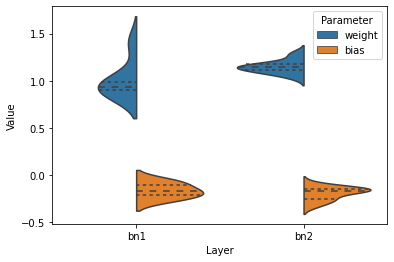

In [ ]:
# Getting model initialized
### For Part 2: only hidden batch norm needed (is True by default)
### We use loader 2 since it comes from standard normalization
trainer=Trainer()
model_q2= LeNet5().to(device)
optimizer = trainer.optimizer(model_q2.parameters(), lr=trainer.learning_rate)
criterion = trainer.criterion()

best_loss=float('inf')

for epoch in range(trainer.num_epochs):
    
    
    train_loss, train_acc = train(model_q2, train_loader_2, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_q2, val_loader_2, criterion, device)


        
    if val_loss < best_loss:
        print("got here")
        best_loss = val_loss
        torch.save(model_q2.state_dict(), 'part2.pt')

    print("In epoch: ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')




model_q2.load_state_dict(torch.load('part2.pt'))
test_loss, test_acc = evaluate(model_q2, test_loader_2, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


bn_params = get_bn_params(model_q2)
create_violin_plots(bn_params)


**Explaination of Question 2**

We prepare our dataset with standard normalization, using mean and variance for the whole dataset.

The only activated flag is batch norm for hidden layers.

Over 10 epochs, both train and validation sets have similar performance. And the best test accuracy is approximately 98%


**Part 3**

got here
In epoch:  1
	Train Loss: 0.182 | Train Acc: 94.78%
	Validation Loss: 0.071 | Validation Acc: 97.94%
got here
In epoch:  2
	Train Loss: 0.055 | Train Acc: 98.27%
	Validation Loss: 0.041 | Validation Acc: 98.72%
In epoch:  3
	Train Loss: 0.044 | Train Acc: 98.60%
	Validation Loss: 0.042 | Validation Acc: 98.72%
got here
In epoch:  4
	Train Loss: 0.034 | Train Acc: 98.93%
	Validation Loss: 0.036 | Validation Acc: 98.90%
In epoch:  5
	Train Loss: 0.029 | Train Acc: 99.05%
	Validation Loss: 0.043 | Validation Acc: 98.74%
got here
In epoch:  6
	Train Loss: 0.025 | Train Acc: 99.19%
	Validation Loss: 0.032 | Validation Acc: 98.94%
In epoch:  7
	Train Loss: 0.022 | Train Acc: 99.30%
	Validation Loss: 0.048 | Validation Acc: 98.69%
got here
In epoch:  8
	Train Loss: 0.020 | Train Acc: 99.32%
	Validation Loss: 0.031 | Validation Acc: 98.97%
In epoch:  9
	Train Loss: 0.017 | Train Acc: 99.42%
	Validation Loss: 0.032 | Validation Acc: 99.02%
In epoch:  10
	Train Loss: 0.016 | Train Acc: 

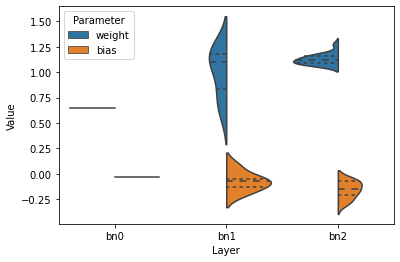

In [ ]:
# Getting model initialized
### We have Batch Normalization for ip and hidden layers. So the flag is set for ipBatchNorm
### Since we have ip batch norm, use data loader 1
trainer=Trainer()
model_q3= LeNet5(ipBatchNorm=True).to(device)
optimizer = trainer.optimizer(model_q3.parameters(), lr=trainer.learning_rate)
criterion = trainer.criterion()

best_loss=float('inf')

for epoch in range(trainer.num_epochs):
    
    
    train_loss, train_acc = train(model_q3, train_loader_1, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_q3, val_loader_1, criterion, device)


        
    if val_loss < best_loss:
        print("got here")
        best_loss = val_loss
        torch.save(model_q3.state_dict(), 'part3.pt')

    print("In epoch: ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')




model_q3.load_state_dict(torch.load('part3.pt'))
test_loss, test_acc = evaluate(model_q3, test_loader_1, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


bn_params = get_bn_params(model_q3)
create_violin_plots(bn_params)


**Explaination of Question 3**

We prepare our batch normalization for hidden layers and input layer. There is no dropout.

Over 10 epochs, training accuracy is higher than validation.

Best test accuracy is approximately 99%

Training performance is better in Q2, but testing performance is better in Q3. This is because when we we use standard norm, the model can overfit better on training data. But with Batch Norm, it learns to generalize better.

So batch norm has a notable improvement on our model performance

When we include batch normalization for input.

1. since training dataset doesn't change with training steps, the weight and biases learned are deterministic without variances.

2. It also reduces the variance/peaks of weights and biases learned in hidden layers.



**Part 4**

got here
In epoch:  1
	Train Loss: 0.901 | Train Acc: 68.06%
	Validation Loss: 0.114 | Validation Acc: 96.97%
got here
In epoch:  2
	Train Loss: 0.610 | Train Acc: 78.10%
	Validation Loss: 0.073 | Validation Acc: 97.90%
got here
In epoch:  3
	Train Loss: 0.579 | Train Acc: 78.79%
	Validation Loss: 0.067 | Validation Acc: 98.06%
got here
In epoch:  4
	Train Loss: 0.556 | Train Acc: 79.54%
	Validation Loss: 0.058 | Validation Acc: 98.20%
got here
In epoch:  5
	Train Loss: 0.545 | Train Acc: 79.93%
	Validation Loss: 0.050 | Validation Acc: 98.38%
got here
In epoch:  6
	Train Loss: 0.533 | Train Acc: 80.29%
	Validation Loss: 0.045 | Validation Acc: 98.58%
got here
In epoch:  7
	Train Loss: 0.527 | Train Acc: 80.37%
	Validation Loss: 0.044 | Validation Acc: 98.62%
got here
In epoch:  8
	Train Loss: 0.526 | Train Acc: 80.38%
	Validation Loss: 0.044 | Validation Acc: 98.70%
got here
In epoch:  9
	Train Loss: 0.522 | Train Acc: 80.62%
	Validation Loss: 0.040 | Validation Acc: 98.70%
got here
I

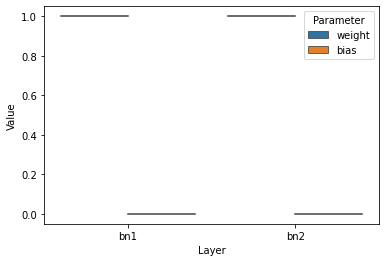

In [ ]:
# Getting model initialized
### We have only dropout so all other flags are set off except hasdropout
# Since input is standard norm, we use loader 2
trainer=Trainer()
model_q4= LeNet5(ipBatchNorm=False,hiddenBatchNorm=False,hasdropout=True).to(device)
optimizer = trainer.optimizer(model_q4.parameters(), lr=trainer.learning_rate)
criterion = trainer.criterion()

best_loss=float('inf')

for epoch in range(trainer.num_epochs):
    
    
    train_loss, train_acc = train(model_q4, train_loader_2, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_q4, val_loader_2, criterion, device)


        
    if val_loss < best_loss:
        print("got here")
        best_loss = val_loss
        torch.save(model_q4.state_dict(), 'part4.pt')

    print("In epoch: ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')




model_q4.load_state_dict(torch.load('part4.pt'))
test_loss, test_acc = evaluate(model_q4, test_loader_2, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


bn_params = get_bn_params(model_q4)
create_violin_plots(bn_params)


**explaination for Q4**

Test accuracy for Q4 is similar to test accuracy for Q3, but marginally higher. Thus it's test accuracy is significantly higher than for Q2.

The training accuracies are however lower since we apply dropout on our training images as well which results in a loss of useful training features. However the generalization resutling from dropout results in good performance on test set.

**Part 5**

got here
In epoch:  1
	Train Loss: 0.830 | Train Acc: 70.69%
	Validation Loss: 0.093 | Validation Acc: 97.46%
got here
In epoch:  2
	Train Loss: 0.574 | Train Acc: 79.14%
	Validation Loss: 0.073 | Validation Acc: 97.82%
got here
In epoch:  3
	Train Loss: 0.557 | Train Acc: 79.61%
	Validation Loss: 0.057 | Validation Acc: 98.55%
got here
In epoch:  4
	Train Loss: 0.541 | Train Acc: 80.12%
	Validation Loss: 0.054 | Validation Acc: 98.50%
In epoch:  5
	Train Loss: 0.532 | Train Acc: 80.18%
	Validation Loss: 0.057 | Validation Acc: 98.42%
got here
In epoch:  6
	Train Loss: 0.527 | Train Acc: 80.32%
	Validation Loss: 0.046 | Validation Acc: 98.77%
In epoch:  7
	Train Loss: 0.521 | Train Acc: 80.57%
	Validation Loss: 0.046 | Validation Acc: 98.74%
got here
In epoch:  8
	Train Loss: 0.520 | Train Acc: 80.54%
	Validation Loss: 0.044 | Validation Acc: 98.90%
In epoch:  9
	Train Loss: 0.517 | Train Acc: 80.64%
	Validation Loss: 0.051 | Validation Acc: 98.55%
got here
In epoch:  10
	Train Loss: 0

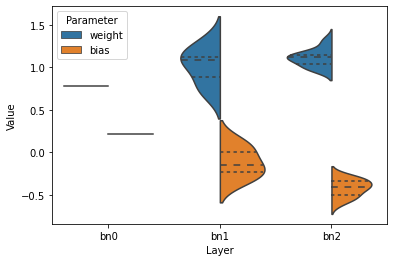

In [ ]:
# Getting model initialized
# All flags on
# Loader 1 since there is batch norm
trainer=Trainer()
model_q5= LeNet5(ipBatchNorm=True,hiddenBatchNorm=True,hasdropout=True).to(device)
optimizer = trainer.optimizer(model_q5.parameters(), lr=trainer.learning_rate)
criterion = trainer.criterion()

best_loss=float('inf')

for epoch in range(trainer.num_epochs):
    
    
    train_loss, train_acc = train(model_q5, train_loader_1, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_q5, val_loader_1, criterion, device)


        
    if val_loss < best_loss:
        print("got here")
        best_loss = val_loss
        torch.save(model_q5.state_dict(), 'part5.pt')

    print("In epoch: ",epoch+1)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')




model_q5.load_state_dict(torch.load('part5.pt'))
test_loss, test_acc = evaluate(model_q5, test_loader_1, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')


bn_params = get_bn_params(model_q5)
create_violin_plots(bn_params)


**explaination of Q5**

When we apply batch norm and dropout, all our flags are switched on.

Thus, it signiciantly overcomes overfitting and produces high testing accuracy. However, the performance is very similar to previous cases where we apply batch norm to every layer or have just dropout.

But due to high dropout, training accuracies aren't as high as cases with only batch norm 

**Question 2**

Pytorch code base: https://github.com/ggflow123/MiniGoogLeNet-PyTorch/blob/main/MiniGoogLeNet.ipynb

In [4]:
#Step One: prepare training data
batch_size=64
VALID_RATIO = 0.9

batchSize = 64

transformations = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                               ])

trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformations)
test = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transformations)


n_train_examples = int(len(trainset) * VALID_RATIO)
n_valid_examples = len(trainset) - n_train_examples

training, valid = data.random_split(trainset, 
                                           [n_train_examples, n_valid_examples])
valid = copy.deepcopy(valid)

train_load = torch.utils.data.DataLoader(dataset=training, batch_size=batch_size, shuffle=True)

val_load = torch.utils.data.DataLoader(dataset=valid, batch_size=batch_size, shuffle=False)

test_load = torch.utils.data.DataLoader(dataset=test, batch_size=batch_size, shuffle=False)


  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [5]:
#Step Two: define your model

class ConvModule(nn.Module): #Defining a skelatal convolution
    def __init__(self, in_channels: int, out_channels: int, kernel_size, stride, padding='same'):
        super(ConvModule, self).__init__()
        self.conv2d = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride=stride, padding=padding)

        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
  
    def forward(self, x): #conv with norm and activation
        x = self.conv2d(x)
        x = self.batchnorm(x)
        x = self.relu(x)

        return x

class InceptionModule(nn.Module): #Define incepction
    def __init__(self, in_channels, ch1x1, ch3x3):
        super(InceptionModule, self).__init__()

        self.conv1x1 = ConvModule(in_channels, ch1x1, (1, 1), 1)
        self.conv3x3 = ConvModule(in_channels, ch3x3, (3, 3), 1)

    def forward(self, x): # We concat two layer sizes
        out1 = self.conv1x1(x)
        out2 = self.conv3x3(x)
        x = torch.cat((out1, out2), 1)
        return x

class DownsampleModule(nn.Module): #downsampling
    def __init__(self, in_channels, out_channels):
        super(DownsampleModule, self).__init__()

        self.conv3x3 = ConvModule(in_channels, out_channels, (3, 3), (2, 2), padding='valid')
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        out1 = self.conv3x3(x)
        out2 = self.maxpool(x)
        x = torch.cat((out1, out2), 1)
        return x
    

class MiniGoogLeNet(nn.Module): #Overal Network
    def __init__(self, classes, input_channels):
        super(MiniGoogLeNet, self).__init__()

        self.conv1 = ConvModule(input_channels, 96, kernel_size=(3, 3), stride=1)
        self.inception1 = InceptionModule(96, 32, 32)
        self.inception2 = InceptionModule(32+32, 32, 48)
        self.downsample1 = DownsampleModule(32+48, 80)

        self.inception3 = InceptionModule(80+80, 112, 48)
        self.inception4 = InceptionModule(112+48, 96, 64)
        self.inception5 = InceptionModule(96+64, 80, 80)
        self.inception6 = InceptionModule(80+80, 48, 96)
        self.downsample2 = DownsampleModule(48+96, 96)

        self.inception7 = InceptionModule(96+96, 176, 160)
        self.inception8 = InceptionModule(176+160, 176, 160)
        self.avgpool2d = nn.AvgPool2d(kernel_size=6)
        self.dropout = nn.Dropout2d(0.5)

        self.fc = nn.Linear(240, classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.inception1(x)
        x = self.inception2(x)
        x = self.downsample1(x)

        x = self.inception3(x)
        x = self.inception4(x)
        x = self.inception5(x)
        x = self.inception6(x)
        x = self.downsample2(x)

        x = self.avgpool2d(x)
        x = self.dropout(x)

        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

**Part One**:

 define your ideal learning rates through cyclical learning rate to find Lr_min and Lr_max


Current Learning rate: 1e-09
Current ecoch:  0
	Train Loss: 2.574 | Train Acc: 9.96%
	Validation Loss: 2.426 | Validation Acc: 10.33%
Current ecoch:  1
	Train Loss: 2.572 | Train Acc: 10.14%
	Validation Loss: 2.430 | Validation Acc: 10.06%
Current ecoch:  2
	Train Loss: 2.576 | Train Acc: 10.03%
	Validation Loss: 2.429 | Validation Acc: 10.11%
Current ecoch:  3
	Train Loss: 2.574 | Train Acc: 10.08%
	Validation Loss: 2.429 | Validation Acc: 10.12%
Current ecoch:  4
	Train Loss: 2.572 | Train Acc: 9.81%
	Validation Loss: 2.433 | Validation Acc: 10.16%
Current Learning rate: 1e-08
Current ecoch:  0
	Train Loss: 2.674 | Train Acc: 9.91%
	Validation Loss: 2.546 | Validation Acc: 10.16%
Current ecoch:  1
	Train Loss: 2.671 | Train Acc: 9.93%
	Validation Loss: 2.543 | Validation Acc: 10.16%
Current ecoch:  2
	Train Loss: 2.673 | Train Acc: 10.02%
	Validation Loss: 2.541 | Validation Acc: 10.16%
Current ecoch:  3
	Train Loss: 2.674 | Train Acc: 9.90%
	Validation Loss: 2.540 | Validation Acc: 

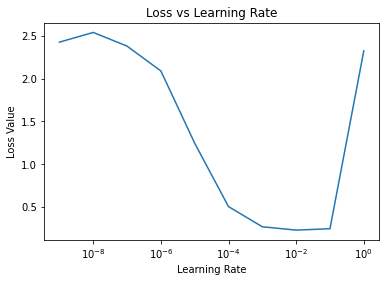

In [ ]:
# Define epochs per lr and each candidate lr
epochs = 5
learning_rates = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1] # 10 candidates

lr_to_loss = {} #Used to link your learning rate to your loss terms
torch.cuda.empty_cache()
for lr in learning_rates:
    print("Current Learning rate:",lr)
    #Model created/initialized from start again
    model = MiniGoogLeNet(classes=10, input_channels=1)
    model.to(device)
    #Training stuff set up
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    best_val_loss=float('inf') #Best
    for epoch in range(epochs): #Over your epochs
        print("Current ecoch: ", epoch)
        # Train and evaluate your model on the training data and the validation dataset
        train_loss,train_acc = train(model,train_load,optimizer,criterion,device)
        val_loss,val_acc = evaluate(model,val_load,criterion,device)
        # Log the losses
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
        print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')
        if best_val_loss > val_loss:
          best_val_loss=val_loss
      
    lr_to_loss[lr] = best_val_loss




def plot_losses(losses):
    plt.plot(list(losses.keys()), list(losses.values()))
    plt.xscale('log')
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss Value')
    plt.title('Loss vs Learning Rate')
    plt.show()

plot_losses(lr_to_loss)

Notes for Part 1:

lrmin (the point  at which learning gets demonstrably better) 10^-4
lrmax (the point  at which learning gets demonstrably worse) 10^-1

Starting **Part 2**

In [7]:
lr_min = 1e-4
lr_max = 1e-1
epochs = 20
step_size = (len(train_load)/batchSize) // 2

model = MiniGoogLeNet(classes=10, input_channels=1).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr_min, momentum=0.9)
scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr=lr_min, max_lr=lr_max, step_size_up=step_size, step_size_down=step_size, gamma=0.9999, mode="exp_range", cycle_momentum=False)
lr_tracker = {}

train_loss_history = []
train_acc_history = []
test_loss_history = []
test_acc_history = []

for epoch in range(epochs):
    print("Current ecoch: ", epoch)
    train_loss,train_acc = train(model,train_load,optimizer,criterion,device)
    val_loss,val_acc = evaluate(model,val_load,criterion,device)
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')
    
    train_acc_history.append(train_acc)
    train_loss_history.append(train_loss)

    test_acc, test_loss = evaluate(model,val_load,criterion,device) # FLipped labels by mistake
    test_acc_history.append(test_acc)
    test_loss_history.append(test_loss)
    

Current ecoch:  0
	Train Loss: 1.509 | Train Acc: 48.25%
	Validation Loss: 0.981 | Validation Acc: 73.27%
Current ecoch:  1
	Train Loss: 0.926 | Train Acc: 69.59%
	Validation Loss: 0.706 | Validation Acc: 76.92%
Current ecoch:  2
	Train Loss: 0.728 | Train Acc: 75.10%
	Validation Loss: 0.597 | Validation Acc: 79.49%
Current ecoch:  3
	Train Loss: 0.634 | Train Acc: 77.73%
	Validation Loss: 0.532 | Validation Acc: 80.65%
Current ecoch:  4
	Train Loss: 0.578 | Train Acc: 79.60%
	Validation Loss: 0.524 | Validation Acc: 80.52%
Current ecoch:  5
	Train Loss: 0.530 | Train Acc: 81.18%
	Validation Loss: 0.454 | Validation Acc: 84.15%
Current ecoch:  6
	Train Loss: 0.497 | Train Acc: 82.44%
	Validation Loss: 0.423 | Validation Acc: 85.39%
Current ecoch:  7
	Train Loss: 0.464 | Train Acc: 83.69%
	Validation Loss: 0.400 | Validation Acc: 85.90%
Current ecoch:  8
	Train Loss: 0.444 | Train Acc: 84.43%
	Validation Loss: 0.386 | Validation Acc: 86.89%
Current ecoch:  9
	Train Loss: 0.423 | Train A

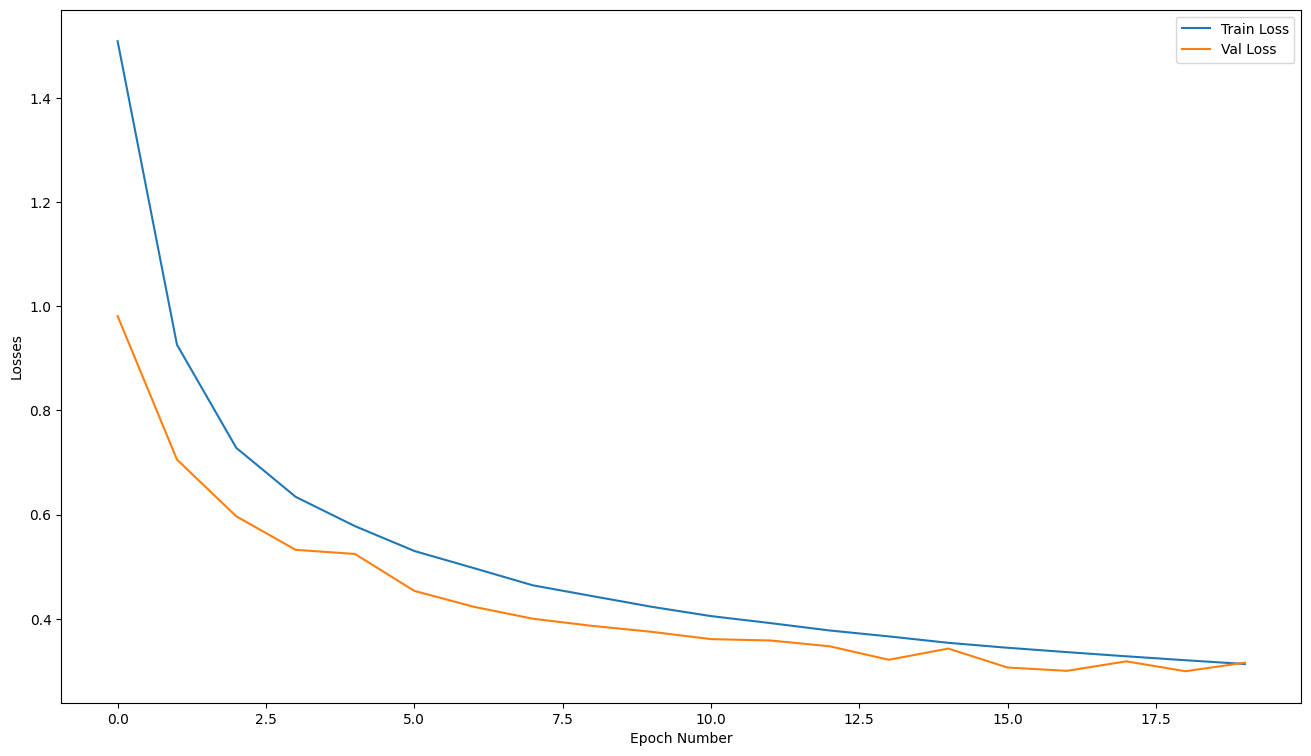

In [13]:
import numpy as np
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(test_acc_history, label='Val Loss') #Therfore flipped it here
plt.ylabel("Losses")
plt.xlabel("Epoch Number")
plt.legend()
plt.show()    

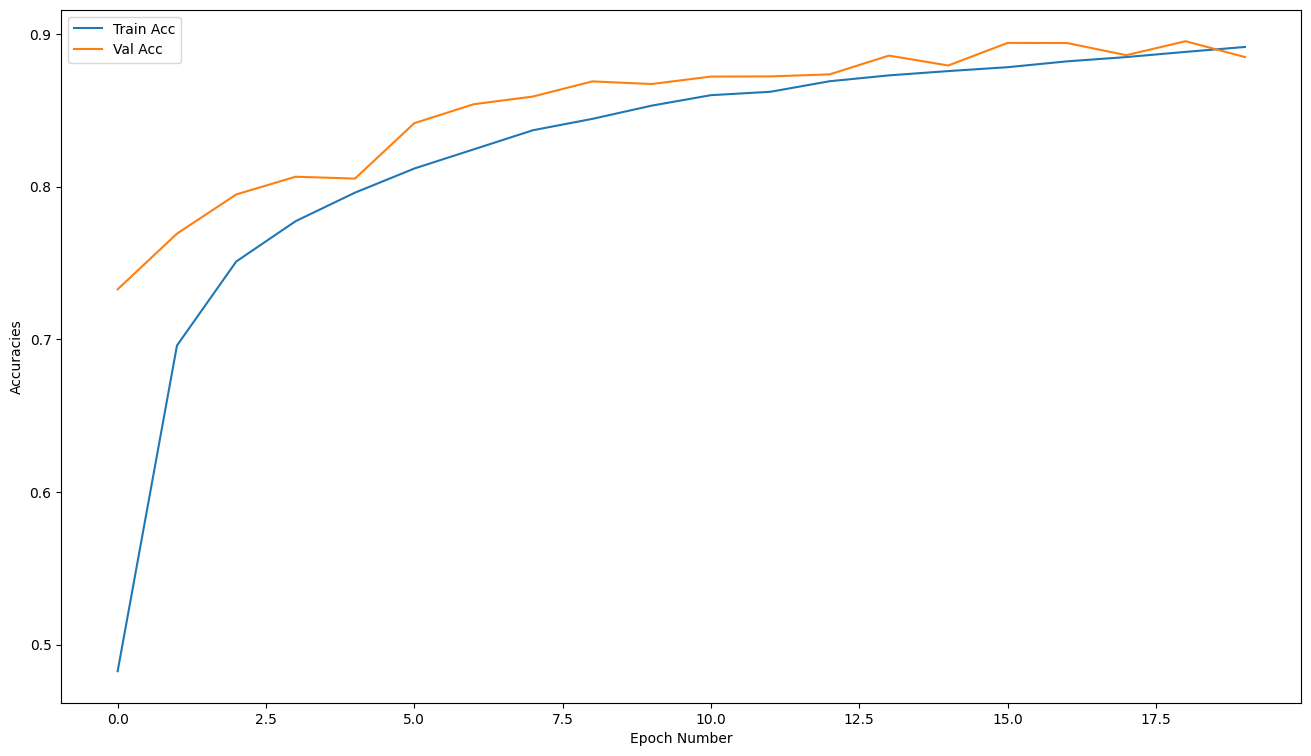

In [14]:
fig, ax = plt.subplots(figsize=(16,9))
plt.plot(train_acc_history, label='Train Acc')  
plt.plot(test_loss_history, label='Val Acc') #Flipped here
plt.ylabel("Accuracies")
plt.xlabel("Epoch Number")
plt.legend()
plt.show() 

In [ ]:
epochs = 10
lr = lr_max
batch_sizes = [2 ** i for i in range(5, 15)]
batch_size_to_loss = {}

for batchSize in batch_sizes:
    print(f"Batch Size: {batchSize}")
    torch.cuda.empty_cache()
    transformations = transforms.Compose([transforms.Resize((32, 32)),
                                transforms.ToTensor(),
                               ])

    training = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transformations)

    n_train_examples = int(len(training) * VALID_RATIO)
    n_valid_examples = len(training) - n_train_examples

    t, v = data.random_split(training, 
                                           [n_train_examples, n_valid_examples])
    v = copy.deepcopy(v)    
    train_set = torch.utils.data.DataLoader(t, batch_size=batchSize, shuffle=True)
    model = MiniGoogLeNet(classes=10, input_channels=1).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    
    best_loss=float('inf')
    for epoch in range(epochs):
      print("Current ecoch: ", epoch)
      train_loss,train_acc = train(model,train_load,optimizer,criterion,device)
      val_loss,val_acc = evaluate(model,val_load,criterion,device)
      print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
      print(f'\tValidation Loss: {val_loss:.3f} | Validation Acc: {val_acc*100:.2f}%')
      if val_loss < best_loss:
        best_loss=val_loss
    batch_size_to_loss[batchSize] = best_loss
    

Batch Size: 32
Current ecoch:  0
	Train Loss: 0.644 | Train Acc: 76.40%
	Validation Loss: 0.558 | Validation Acc: 81.04%
Current ecoch:  1
	Train Loss: 0.388 | Train Acc: 85.91%
	Validation Loss: 0.329 | Validation Acc: 87.84%
Current ecoch:  2
	Train Loss: 0.322 | Train Acc: 88.59%
	Validation Loss: 0.308 | Validation Acc: 89.12%
Current ecoch:  3
	Train Loss: 0.283 | Train Acc: 89.98%
	Validation Loss: 0.260 | Validation Acc: 90.75%
Current ecoch:  4
	Train Loss: 0.259 | Train Acc: 90.70%
	Validation Loss: 0.229 | Validation Acc: 91.95%
Current ecoch:  5
	Train Loss: 0.238 | Train Acc: 91.49%
	Validation Loss: 0.255 | Validation Acc: 90.64%
Current ecoch:  6
	Train Loss: 0.225 | Train Acc: 92.05%
	Validation Loss: 0.212 | Validation Acc: 92.53%
Current ecoch:  7
	Train Loss: 0.209 | Train Acc: 92.53%
	Validation Loss: 0.419 | Validation Acc: 86.61%
Current ecoch:  8
	Train Loss: 0.196 | Train Acc: 93.07%
	Validation Loss: 0.202 | Validation Acc: 92.67%
Current ecoch:  9
	Train Loss: 

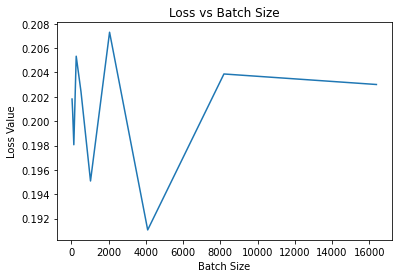

In [ ]:
import math
def plot_losses_batch_version(losses):
    plt.plot(list(losses.keys()), list(losses.values()))
    plt.xlabel('Batch Size')
    plt.ylabel('Loss Value')
    plt.title('Loss vs Batch Size')
    plt.show()

plot_losses_batch_version(batch_size_to_loss)

**Compare Part 1 to Part 3**

In Part 1, we observe the affect of increasing learning rate on model performance. 

Initial low learning rates contribute to high losses due to the model's inability to descent along the gradient fast enough.

From there we observe a region where increasing lr significatnly improves model performance before finally reaching a point where increasing learning rate causes oscillations that have a negative impact on learning.

If we start at a high lr before reducing lr; we'd see high losses with oscillations before a drop and then a rise again with no oscillations (associated with small lr). This is exactly what we observe for increasing batch sizes.

That is because both high learning rates and low batch sizes are associated with a lot of weight updates that are too high and low learning rates and high batch sizes are linked to models not making enough updates and learning very slowly.

**Comparing Part 2 and Part 3**

Part 3 generalizes a lot better and has higher validation accuracies and lower losses.

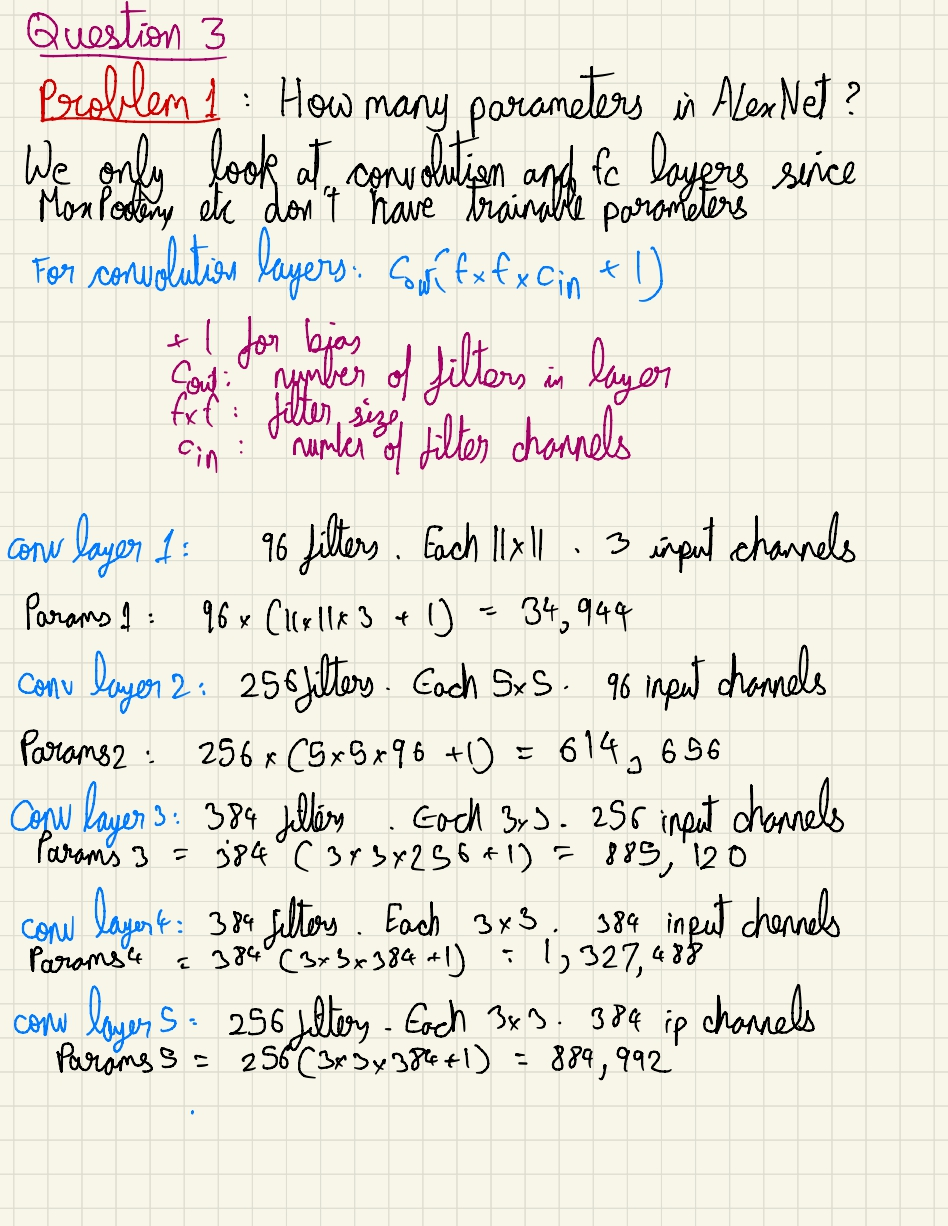

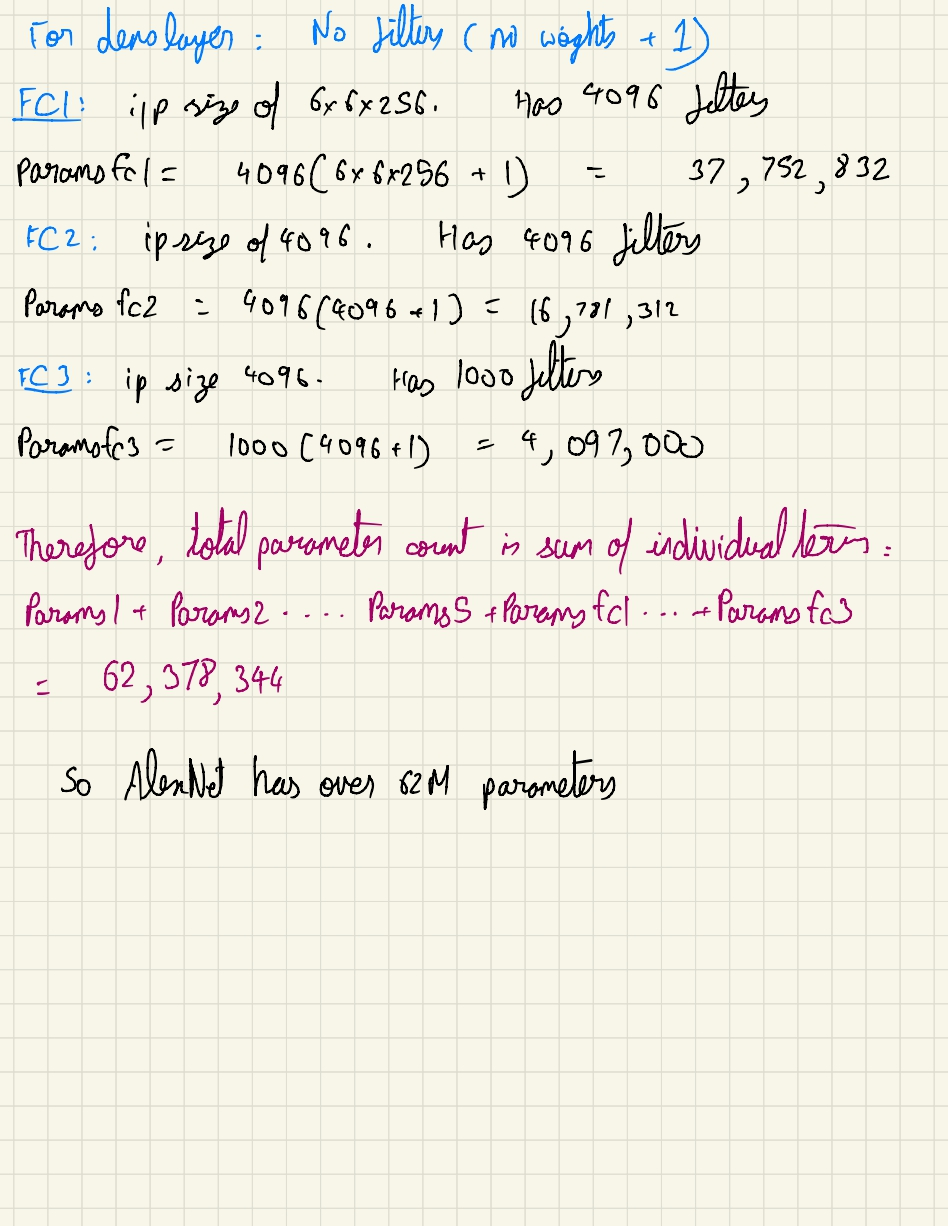

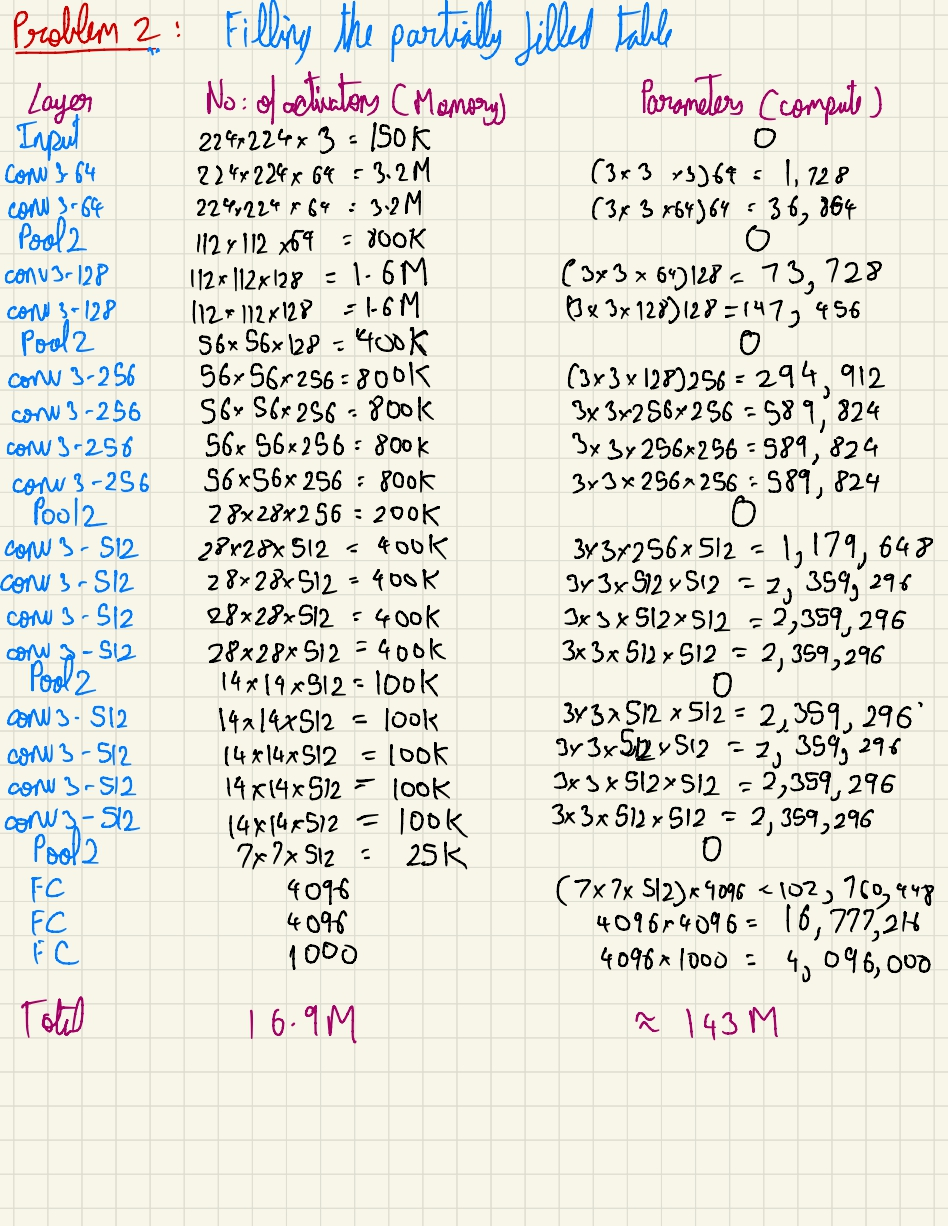

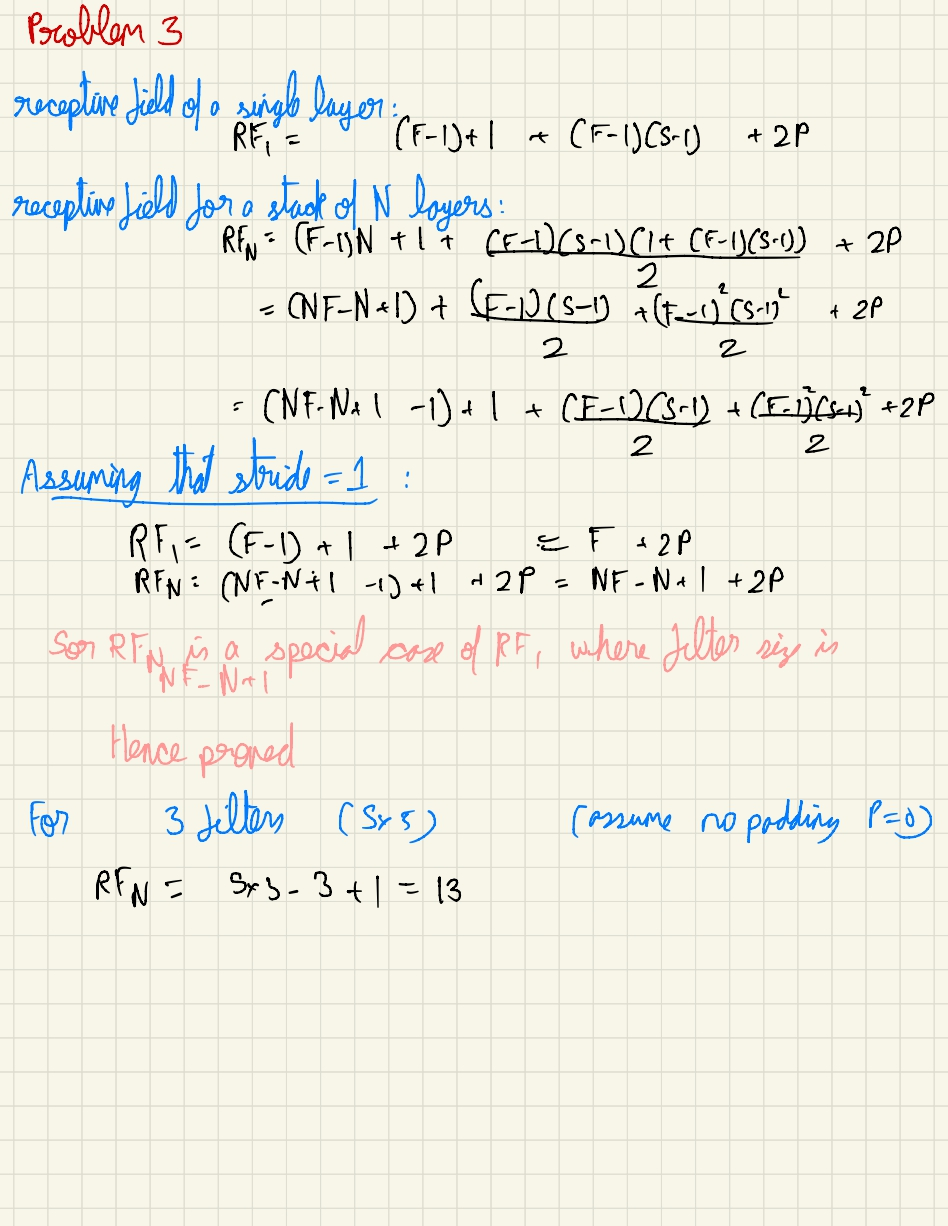

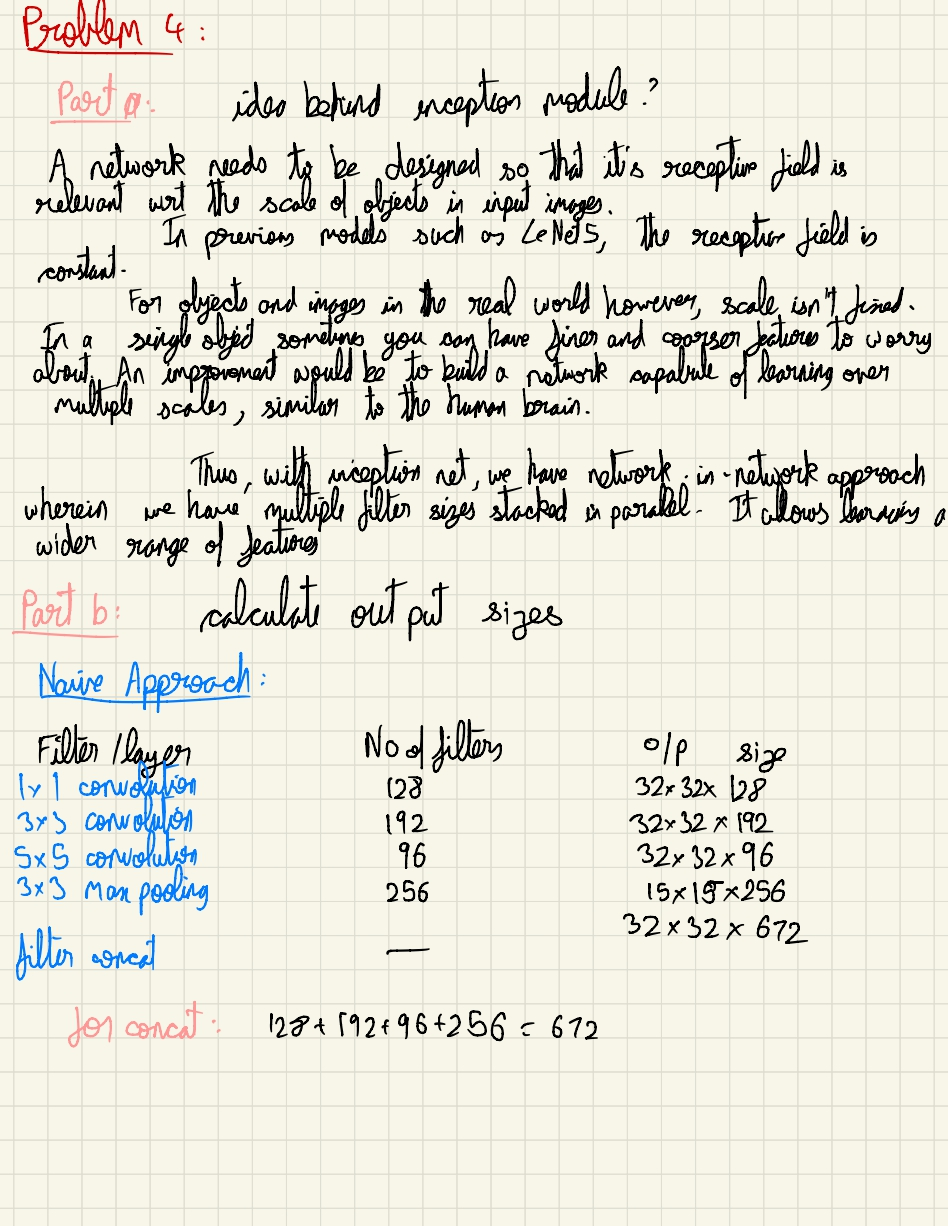

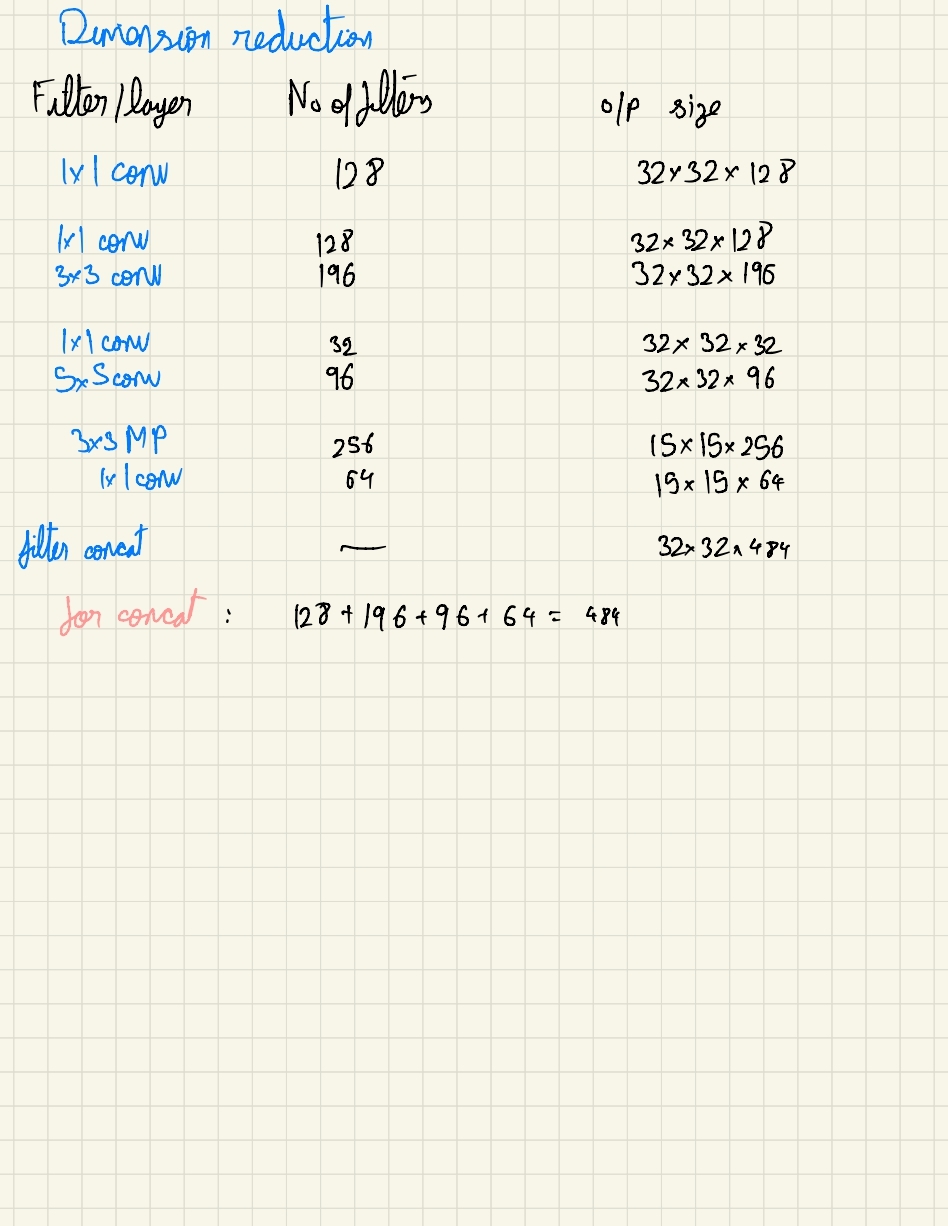

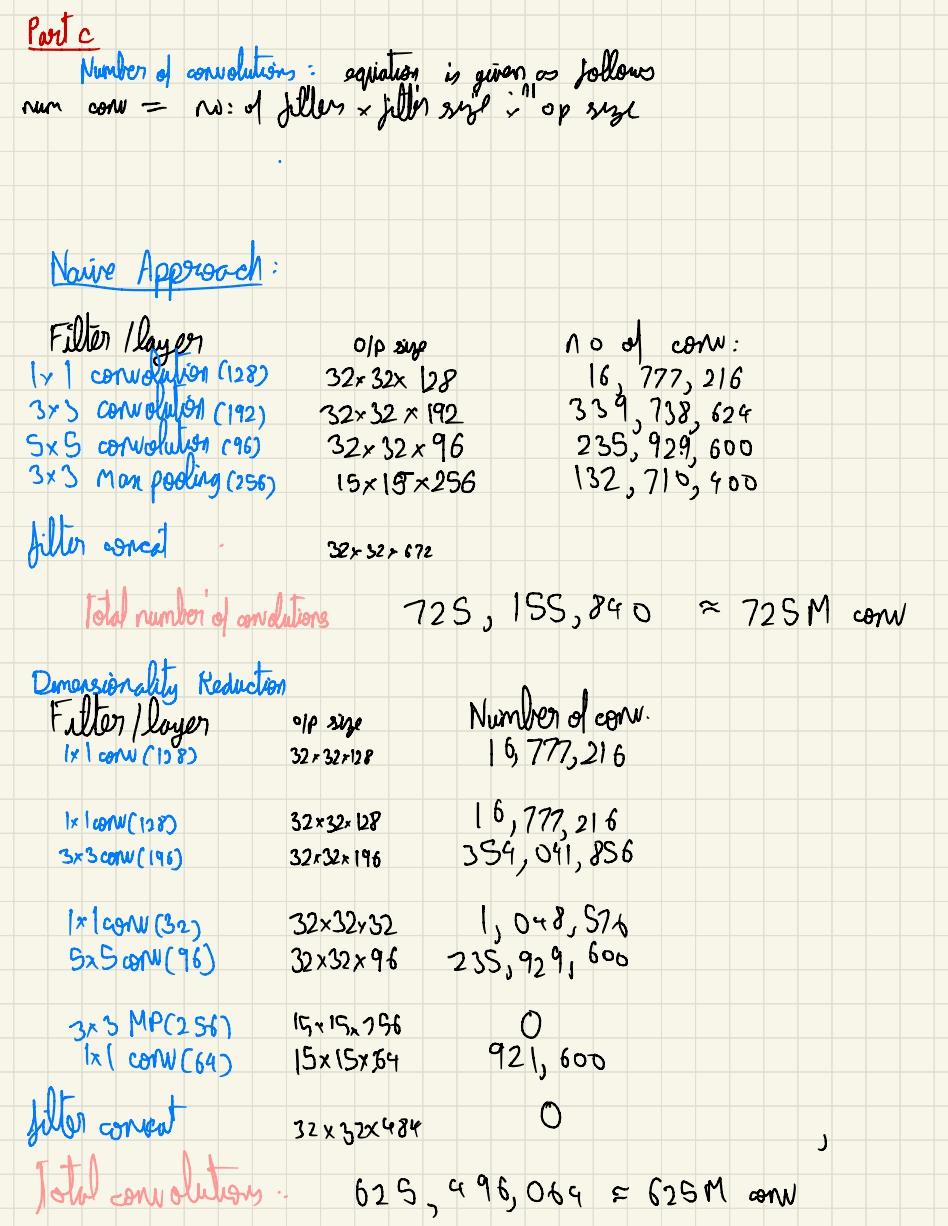

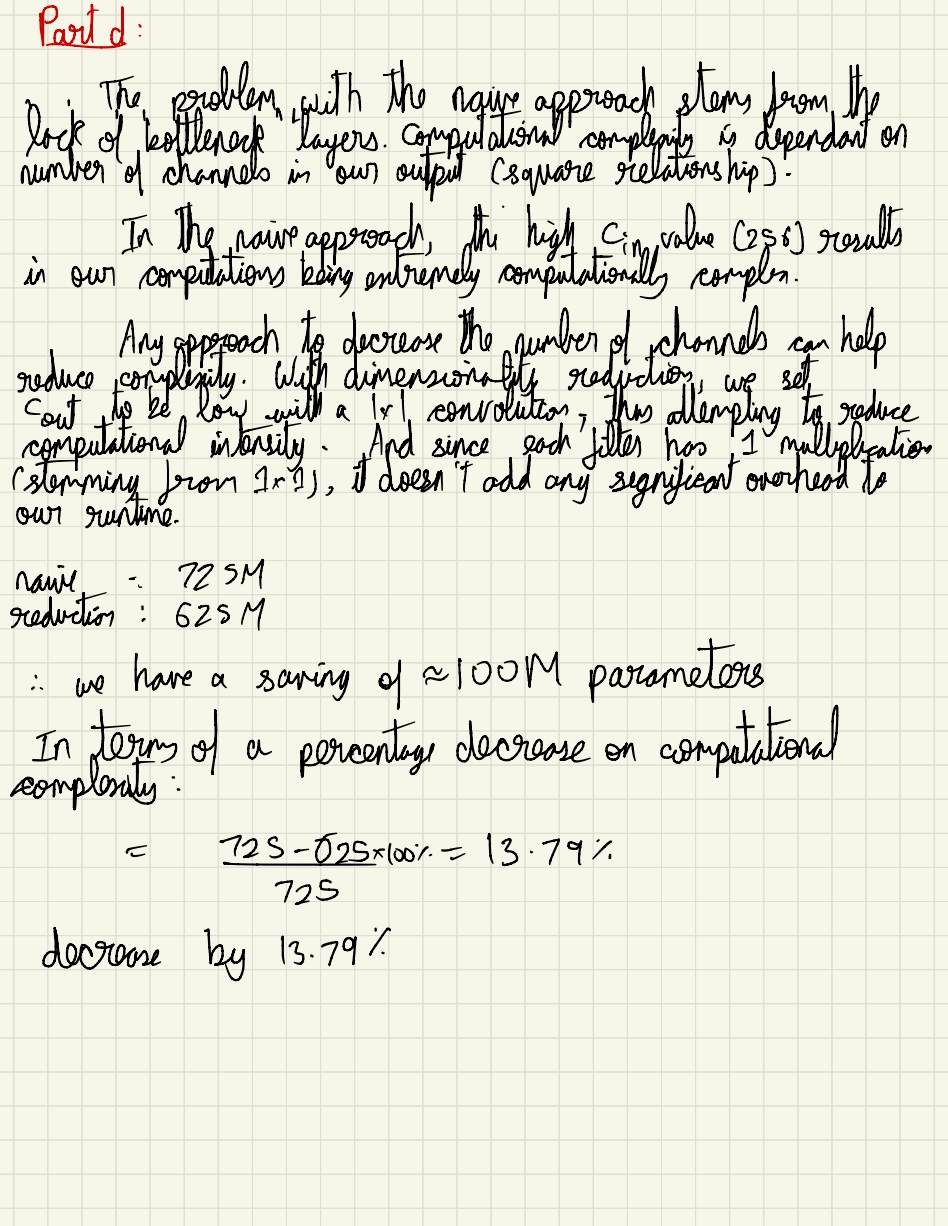